In [1]:
import numpy as np
import cvxpy as cp
import itertools as it
import scipy.linalg as spla
import matplotlib.pyplot as plt
import pennylane as qml

In [2]:
def pauli_basis(n):
    I = np.eye(2).astype(complex)
    X = np.array([[0, 1], [1, 0]], complex)
    Y = np.array([[0, -1j], [1j, 0]], complex)
    Z = np.array([[1, 0], [0, -1]], complex)
    basis = {
        "labels": [],
    }
    b = []
    for comb in list(it.product([0, 1, 2, 3], repeat=n))[1:]:
        p = 1.
        basis["labels"].append(comb)
        for c in comb:
            if c == 0:
                p = np.kron(p, I)
            elif c == 1:
                p = np.kron(p, X)
            elif c == 2:
                p = np.kron(p, Y)
            elif c == 3:
                p = np.kron(p, Z)
        b.append(p)
    basis["basis"] = np.stack(b)
    return basis

def specific_basis_terms(basis, specific_labels, ts):
    theta = []
    for l in basis["labels"]:
        if l in specific_labels:
            theta.append(ts[specific_labels.index(l)])
        else:
            theta.append(0)
    return np.array(theta)

def two_body_projection_indices(basis):
    basis_indices = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            basis_indices.append(1)
        else:
            basis_indices.append(0)
    return basis_indices

def two_body_projection(theta, basis):
    indices = two_body_projection_indices(basis)
    return np.array([t * indices[i] for i,t in enumerate(theta)])

def geodesic_ham(U, V):
    gamma = -1.j * spla.logm(U.conj().T @ V)
    return gamma

def unitary_from_parameters(parameters, basis):
    h = hamiltonian_from_parameters(parameters, basis)
    return spla.expm(1.j*h)

def hamiltonian_from_parameters(parameters, basis):
    return np.einsum("ijk,i->jk", basis, parameters)

def parameters_from_hamiltonian(hamiltonian, basis):
    return np.real(np.einsum("ijk, kj->i", basis, hamiltonian)) / (len(hamiltonian[0]))

def parameters_from_unitary(unitary, basis):
    h = -1.j * spla.logm(unitary)
    return np.real(np.einsum("ijk, kj->i", basis, h)) / (len(h[0]))

def unitary_fidelity(U1, U2):
    return np.abs(np.trace(U1.conj().T @ U2))/len(U1[0])

def phi_fidelity(phi, phi_basis, U2):
    phi_H = hamiltonian_from_parameters(phi, phi_basis)
    phi_U = spla.expm(1.j * phi_H)
    return unitary_fidelity(phi_U, U2)

def plot_parameters(labels, parameters, title=False, figsize=[14,6]):
    labels = ["".join(map(str, l)) for l in labels]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(labels,parameters)
    ax.grid()
    if title:
        plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_fidelities(steps, fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    ax.plot(steps, fidelities)
    if title:
        plt.title(title)
    plt.show()
    
def plot_multi_fidelities(multi_steps, multi_fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    for i, fidelities in enumerate(multi_fidelities):
        fid = [1 - f for f in fidelities] 
        ax.plot(multi_steps[i], fid)
    if title:
        plt.title(title)
    ax.set_yscale('log')
    ax.set_xlabel("Step")
    ax.set_ylabel("1 - fidelity")
    plt.show()
    
def plot_multi_step_sizes(multi_steps, multi_step_sizes, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    for i, s in enumerate(multi_step_sizes):
        ax.plot(multi_steps[i], s)
    if title:
        plt.title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Step size")
    plt.show()

def plot_direction_indices(indices, title=False):
    plt.hist(indices, bins=len(indices))
    if title:
        plt.title(title)
    plt.show()

In [3]:
def commutator(A, B):
    return (A @ B) - (B @ A)

def trace_norm(A, B=None):
    if B is None:
        norm = np.trace(A.conj().T @ A)
    else:
        norm = np.trace(A.conj().T @ B)
    return norm

In [4]:
nqubits = 3
basis_full = pauli_basis(nqubits)

Vtoff = np.array([[1,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,1],
                  [0,0,0,0,0,0,1,0]])

Vcch = np.array([[1,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,1/np.sqrt(2), 1/np.sqrt(2)],
                  [0,0,0,0,0,0,1/np.sqrt(2), -1/np.sqrt(2)]])

Vfred = np.array([[1,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,1]])

w = np.exp(1.j * 2 * np.pi / 8)
Vqft = (1/np.sqrt(8)) * np.array([[1,1,1,1,1,1,1,1],
                 [1, w, w**2, w**3, w**4, w**5, w**6, w**7],
                 [1, w**2, w**4, w**6, w**8, w**10, w**12, w**14],
                 [1, w**3, w**6, w**9, w**12, w**15, w**18, w**21],
                 [1, w**4, w**8, w**12, w**16, w**20, w**24, w**28],
                 [1, w**5, w**10, w**15, w**20, w**25, w**30, w**35],
                 [1, w**6, w**12, w**18, w**24, w**30, w**36, w**42],
                 [1, w**7, w**14, w**21, w**28, w**35, w**42, w**49]])

theta0 = parameters_from_hamiltonian(-1.j*spla.logm(Vtoff), basis_full["basis"])

def multikron(matrices):
    product = matrices[0]
    for mat in matrices[1:]:
        product = np.kron(product, mat)
    return product

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])

VparityZ = (multikron([I,I,I,I,I]) + multikron([Z,Z,Z,Z,I]) + multikron([I,I,I,I,X]) - multikron([Z,Z,Z,Z,X]))/2
VparityZ3 = (multikron([I,I,I,I]) + multikron([Z,Z,Z,I]) + multikron([I,I,I,X]) - multikron([Z,Z,Z,X]))/2
VparityZ2 = (multikron([I,I,I]) + multikron([Z,Z,I]) + multikron([I,I,X]) - multikron([Z,Z,X]))/2

In [97]:
theta1 = parameters_from_hamiltonian(-1.j*spla.logm(np.exp(1.j * 0.234)*Vtoff), basis_full["basis"])

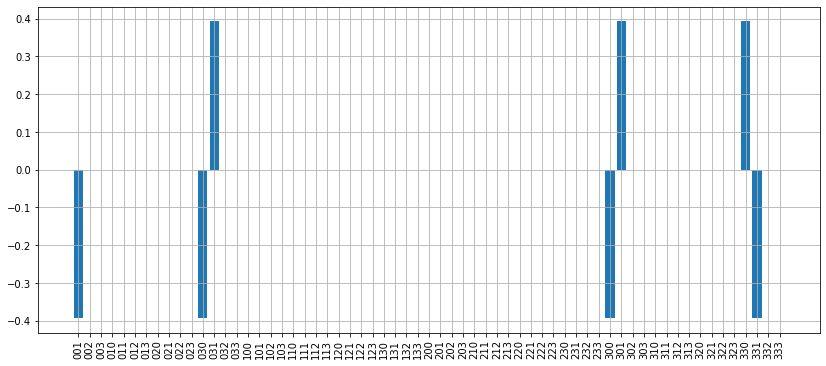

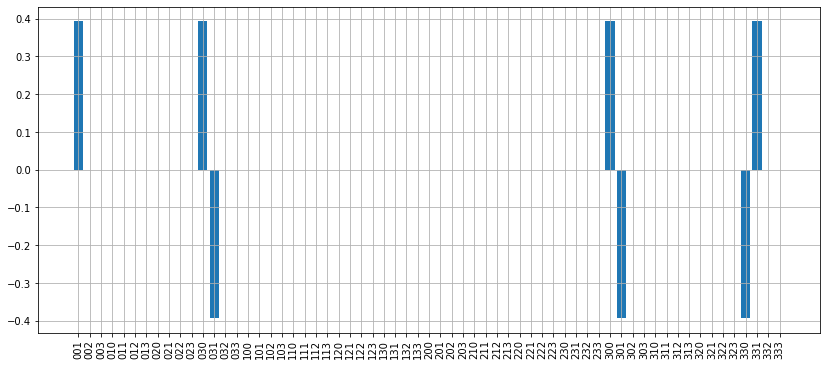

In [98]:
plot_parameters(basis_full["labels"], theta0)
plot_parameters(basis_full["labels"], theta1)

In [99]:
theta0 = parameters_from_hamiltonian(-1.j*spla.logm(np.exp(1.j * 0.1)*Vtoff), basis_full["basis"])

In [256]:
eigs = spla.eig(Vtoff, left=True)
eigs[1] - eigs[2]

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [271]:
eigsystem = spla.eig(Vtoff)
eigvalues = eigsystem[0]
eigvectors = eigsystem[1]

d = np.diag(eigvalues)
p = eigvectors

In [272]:
p @ d @ p.conj().T

array([[ 1.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  1.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  1.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         1.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  1.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j,  0.000

In [270]:
eigvalues[1]

(-1+0j)

In [273]:
sum([eigvalues[i]*np.outer(v,v) for i, v in enumerate(eigvectors.T)])

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [136]:
R = p @ np.diag([np.sqrt(np.exp(1.))]) @ p.conj().T

In [148]:
random_phi = np.random.rand(len(basis_full["basis"]))-1/2
U_random = unitary_from_parameters(random_phi, basis_full["basis"])

In [154]:
Vtoff_rotated = Vtoff @ spla.expm(np.diag([1]*8) * 1.1j)

In [155]:
unitary_fidelity(Vtoff, Vtoff_rotated)

1.0

In [157]:
gamma = -1.j * spla.logm(U_random.conj().T @ Vtoff)
gamma_rot = -1.j * spla.logm(U_random.conj().T @ Vtoff_rotated)

In [160]:
gamma = -1.j * spla.logm(Vtoff)
gamma_rot = -1.j * spla.logm(Vtoff_rotated)

In [162]:
gamma_rot

array([[ 1.1       -6.93889390e-17j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j],
       [ 0.        -0.00000000e+00j,  1.1       -6.93889390e-17j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j],
       [ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         1.1       -6.93889390e-17j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j],
       [ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  1.1       -6.93889390e-17j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
       

In [145]:
commutator(R, Vtoff)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [170]:
Htoff = -1.j*spla.logm(Vtoff)

In [142]:
HtoffR = R.conj().T @ Htoff @ R

In [232]:
m_vec = [1,2,2,2,7,7,5,11]

In [281]:
m_vec = np.random.rand(8)

In [282]:
H0 = -1.j * sum([np.log(eigvalues[i]) * np.outer(v,v.conj().T) for i, v in enumerate(eigvectors.T)]) 

In [283]:
H0

array([[ 0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j],
       [ 0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j],
       [ 0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j],
       [ 0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j],
       [ 0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j],
       [ 0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j,  0.        -0.j,
         0.        -0.j,  0.        -0.j],
       [ 0.        -0.j,  0.      

In [284]:
spla.expm(1.j*H0)

array([[ 1.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
       [ 0.00000000e+00-0.00000000e+00j,  1.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
       [ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         1.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
       [ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e

In [285]:
HtoffR = H0 + (2 * np.pi * sum([m_vec[i]*np.outer(v,v.conj().T) for i, v in enumerate(eigvectors)]))

In [286]:
spla.expm(1.j * HtoffR)

array([[ 0.44538499+0.11434731j, -0.22082372+0.86011266j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.22082372+0.86011266j,  0.44538499+0.11434731j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.05556103-0.99845529j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.9998886 +0.01492616j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0

In [287]:
unitary_fidelity(spla.expm(1.j*Htoff),spla.expm(1.j*HtoffR))

0.22682897682957104

In [144]:
spla.expm(1.j*HtoffR)

array([[1.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ],
       [0.        -0.j        , 1.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ],
       [0.        -0.j        , 0.        -0.j        ,
        1.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ],
       [0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 1.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ,
        0.        -0.j        , 0.        -0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0

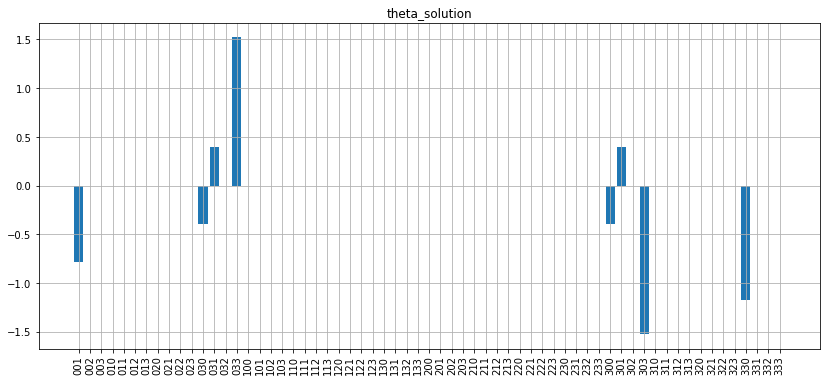

In [340]:
specific_labels = [(3,0,0), (0,3,0), (3,0,1), (0,3,1), (3,3,0), (0,0,1), (0,3,3), (3,0,3)]
ts = [-np.pi/8, -np.pi/8, np.pi/8, np.pi/8, -3*np.pi/8, -2*np.pi/8, np.sqrt(15)*np.pi/8, -np.sqrt(15)*np.pi/8]

theta_solution = specific_basis_terms(basis_full, specific_labels, ts)
Htoff_2 = hamiltonian_from_parameters(theta_solution, basis_full["basis"])

plot_parameters(basis_full["labels"], theta_solution, "theta_solution")

In [401]:
-1.j*spla.logm(spla.expm(1.j*np.diag([1]*8)))

array([[1.-2.77555756e-17j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j],
       [0.-0.00000000e+00j, 1.-2.77555756e-17j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j],
       [0.-0.00000000e+00j, 0.-0.00000000e+00j, 1.-2.77555756e-17j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j],
       [0.-0.00000000e+00j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        1.-2.77555756e-17j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j],
       [0.-0.00000000e+00j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 1.-2.77555756e-17j, 0.-0.00000000e+00j,
        0.-0.00000000e+00j, 0.-0.00000000e+00j],
       [0.-0.00000000e+00j, 0.-0.00000000e+00j, 0.-0.00000000e+00j,
       

In [396]:
Hv = Htoff_2 - Htoff
commutator(Htoff, Hv)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [389]:
unitary_fidelity(spla.expm(1.j*Htoff), spla.expm(1.j*Htoff_2))

0.9999999999999999

In [394]:
unitary_fidelity(Vtoff,spla.expm(1.j*Htoff)@spla.expm(1.j*np.outer(eigvectors[:,1],eigvectors[:,1])))

0.9483887016454043

In [382]:
Htoff = Htoff
eigsystem_Htoff = spla.eig(Htoff)
eigvalues_Htoff = eigsystem_Htoff[0]
eigvectors_Htoff = eigsystem_Htoff[1]

D = np.diag(eigvalues_Htoff)
P = eigvectors_Htoff

D

array([[ 3.14159265e+00+3.60822483e-16j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -2.34557046e-48-1.74315280e-32j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e

In [385]:
# Htoff_2_I = Htoff_2 + 3.1415926535897927/8*np.diag([1]*8)
Htoff_2_I = Htoff_2 
eigsystem_Htoff_2_I = spla.eig(Htoff_2_I)
eigvalues_Htoff_2_I = eigsystem_Htoff_2_I[0]
eigvectors_Htoff_2_I = eigsystem_Htoff_2_I[1]

D_2_I = np.diag(eigvalues_Htoff_2_I)
P_2_I = eigvectors_Htoff_2_I

D_2_I

array([[ 1.17809725+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j, -1.96349541+0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j, -1.96349541+0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         4.3196899 +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  4.3196899 +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j, -1.96349541+0.j,
         0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.      

In [369]:
Htoff

array([[ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j],
       [ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j],
       [ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j],
       [ 0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
         0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
       

In [ ]:
Htoff_2_I = 

In [ ]:
Htoff

In [370]:
spla.eig(Htoff_2_I)

(array([ 1.57079633+0.j, -1.57079633+0.j, -1.57079633+0.j,  4.71238898+0.j,
         4.71238898+0.j, -1.57079633+0.j, -1.57079633+0.j, -1.57079633+0.j]),
 array([[-0.        -0.j,  0.        +0.j, -0.        -0.j,
          0.        +0.j, -0.        -0.j,  0.        +0.j,
          1.        +0.j,  0.        +0.j],
        [-0.        -0.j,  0.        +0.j, -0.        -0.j,
          0.        +0.j, -0.        -0.j,  0.        +0.j,
          0.        +0.j,  1.        +0.j],
        [-0.        -0.j,  0.        +0.j,  0.9920297 +0.j,
         -0.12600429+0.j, -0.        -0.j,  0.        +0.j,
          0.        +0.j,  0.        +0.j],
        [-0.        -0.j,  0.        +0.j,  0.12600429-0.j,
          0.9920297 +0.j, -0.        -0.j,  0.        +0.j,
          0.        +0.j,  0.        +0.j],
        [-0.        -0.j,  0.        +0.j, -0.        -0.j,
          0.        +0.j,  0.9920297 +0.j,  0.12600429+0.j,
          0.        +0.j,  0.        +0.j],
        [-0.        -0.j, 

In [371]:
spla.eig(Htoff)

(array([ 3.14159265e+00+3.60822483e-16j, -2.34557046e-48-1.74315280e-32j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j]),
 array([[-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          1.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
        [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          0.        +0.00000000e+00j,  1.        +0.00000000e+00j,
          0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
        [-0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
          1.        +0.0000000

In [372]:
sum(spla.eig(Htoff_2_I)[0])

(3.141592653589794+0j)

In [373]:
sum(spla.eig(Htoff)[0])

(3.1415926535897927+3.6082248300317583e-16j)

In [330]:
Vtoff_2 = unitary_from_parameters(theta_solution, basis_full["basis"])
(1/(-3.82683432e-01-9.23879533e-01j))*Vtoff_2

array([[ 1.00000000e+00-5.24321198e-10j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j],
       [-0.00000000e+00+0.00000000e+00j,  1.00000000e+00-5.24321198e-10j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j],
       [-0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
         1.00000000e+00-5.24321531e-10j, -7.99792355e-18-5.85433179e-17j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j],
       [-0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
        -1.52270614e-17-6.73939839e

In [376]:
unitary_fidelity(spla.expm(1.j*Htoff_2_I), spla.expm(1.j*Htoff))

0.9999999999999999

In [169]:
Htoff - Htoff_2

array([[ 1.96349541e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
       [ 0.00000000e+00-0.00000000e+00j,  1.96349541e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
       [ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         1.86373676e+00-0.00000000e+00j,  7.85398163e-01-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j],
       [ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
         7.85398163e-01-0.00000000e

In [335]:
VtoffR = Vtoff @ spla.expm(-1.9634954079692992j * np.diag([1]*8)) @ spla.expm(-1.9634954079692992j * np.outer(eigvectors[:,1], eigvectors[:,1].conj().T))

In [339]:
VtoffR

array([[-0.38268343-0.92387953j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.38268343-0.92387953j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.38268343-0.92387953j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.38268343-0.92387953j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0

In [332]:
VtoffR - Vtoff_2

array([[ 4.84409790e-10-2.00648942e-10j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  4.84409790e-10-2.00648942e-10j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         4.84410012e-10-2.00649386e-10j,  5.10263003e-17-2.97926757e-17j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         5.64367782e-17-3.98585314e

In [338]:
unitary_fidelity(VtoffR, Vtoff)

0.8351874036862035

In [326]:
HtoffR = -1.j*spla.logm(VtoffR)

In [323]:
Htoff = -1.j*spla.logm(Vtoff)

In [327]:
HtoffR

array([[1.96349541-5.55111512e-17j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j],
       [0.        -0.00000000e+00j, 1.96349541-5.55111512e-17j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j],
       [0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        1.96349541-5.55111512e-17j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j],
       [0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 1.96349541-5.55111512e-17j,
        0.        -0.00000000e+00j, 0.        -0.00000000e+00j,
        0.        -0.00000000e+00j, 0

In [301]:
HtoffR - Htoff

array([[ 1.        -2.77555756e-17j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  1.        -2.77555756e-17j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         1.        -2.77555756e-17j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  1.        -2.77555756e-17j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
       

In [315]:
spla.expm(1.j*HtoffR)

array([[ 5.40302306e-01+8.41470985e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  5.40302306e-01+8.41470985e-01j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         5.40302306e-01+8.41470985e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e

In [308]:
unitary_fidelity(spla.expm(1.j*HtoffR), spla.expm(1.j*Htoff))

0.9999999999999999

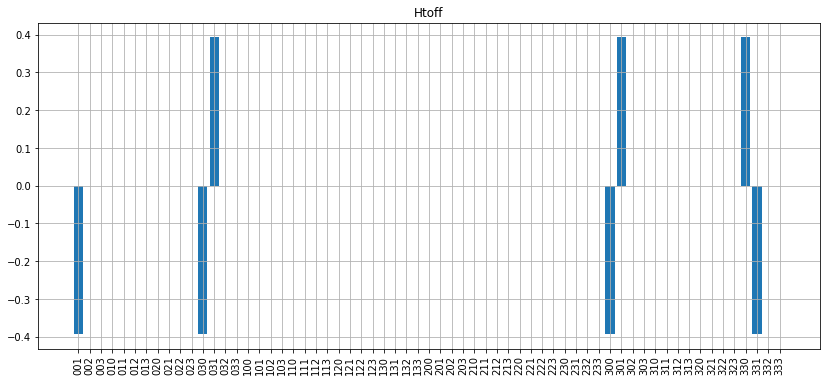

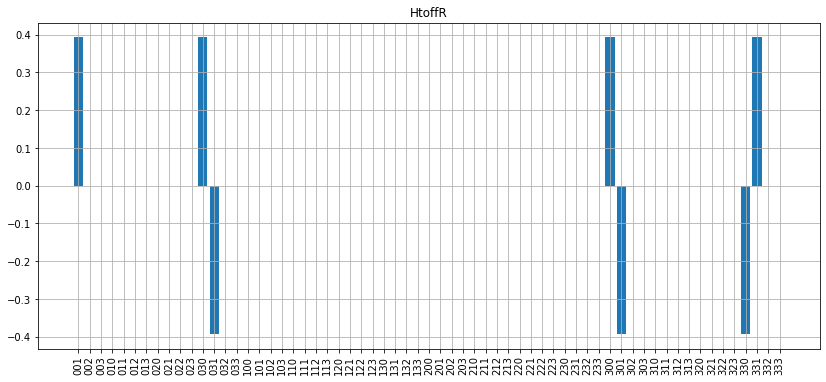

In [309]:
H_phis = []

phis = np.linspace(0, 2*np.pi, 1000)

HtoffR_params = parameters_from_hamiltonian(HtoffR, basis_full["basis"])
Htoff_params = parameters_from_hamiltonian(Htoff, basis_full["basis"])

plot_parameters(basis_full["labels"], Htoff_params, "Htoff")
plot_parameters(basis_full["labels"], HtoffR_params, "HtoffR")

In [5]:
def golden_section_search(f, a, b, tol=1e-5):
    """Golden-section search.

    Given a function f with a single local minimum in
    the interval [a,b], gss returns a subset interval
    [c,d] that contains the minimum with d-c <= tol.
    
    Example:
    f = lambda x: (x-2)**2
    a = 1
    b = 5
    tol = 1e-5
    (c,d) = gss(f, a, b, tol)
    print(c, d)
    1.9999959837979107 2.0000050911830893
    source: https://en.wikipedia.org/wiki/Golden-section_search
    """

    (a, b) = (min(a, b), max(a, b))
    h = b - a
    if h <= tol:
        return (a, b)

    # Required steps to achieve tolerance
    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))
    
    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)
    
    for k in range(n-1):
        if yc > yd: 
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)
    if yc < yd:
        return c, yc
    else:
        return d, yd

In [6]:
invphi = (np.sqrt(5) - 1) / 2  # 1 / phi
invphi2 = (3 - np.sqrt(5)) / 2  # 1 / phi^2

def geodesic_direction_update_step(target_V, phi, phi_basis, step_size=0.01, precision=0.9999, step_count=(None,None)):
    # Step 0: find the unitary from phi
    phi_H = hamiltonian_from_parameters(phi, phi_basis["basis"])
    phi_U = spla.expm(1.j * phi_H)
    
    # Step 1: find the geodesic between phi_U and target_V
#     gamma = 0.1*np.diag([1]* int(np.sqrt(len(phi)+1)))
    gamma = geodesic_ham(phi_U, target_V)
    gamma_phi = parameters_from_hamiltonian(gamma, phi_basis["basis"])
#     print(gamma_phi)
    
    # Step 2: find the Omegas
    projected_indices = two_body_projection_indices(phi_basis)
#     projected_indices = [1 for _ in phi_basis["basis"]]

    su = qml.SpecialUnitary(phi, [i for i in range(nqubits)])
    omegas = 1.j * su.get_one_parameter_generators(interface="jax")
#     print(omegas)
    omega_phis = np.array([projected_indices[i] * parameters_from_hamiltonian(omega, phi_basis["basis"]) for i, omega in enumerate(omegas)])
#     omega_phis_squared = np.array[omega @ omega for omega in omegas]
#     plot_parameters(basis_full["labels"], omega_phis[13], title="omega_phis[13]")
#     print(omegas[60])

    # Step 3: Find a linear combination of Omegas that gives the geodesic and update parameters
#     print(f"omega_phis[0] = {omega_phis[0]}")
#     coeffs = linear_combination_coeffs(omega_phis, gamma_phi)
    coeffs = linear_combination_projected_coeffs(omega_phis, gamma_phi, projected_indices)
#     phi_U_Omegas = np.array([phi_U @ omega for omega in omegas])
#     print(phi_U_Omegas[60])
#     coeffs = linear_combination_U_Omegas(phi_U_Omegas, 1.j * step_size * phi_U @ gamma)
#     coeffs = linear_combination_omegas(omegas, step_size * gamma)

#     plot_parameters(phi_basis["labels"], coeffs)
#     omega_update = sum([coeffs[i] * omega for i, omega in enumerate(omegas)])
#     print(f"Trace norm omega_update = {trace_norm(omega_update)}")
#     print(f"Trace norm gamma = {trace_norm(gamma)}")
#     omega_update /= np.sqrt(trace_norm(omega_update))
#     gamma /= np.sqrt(trace_norm(gamma))
#     print(f"Trace norm omega_update = {trace_norm(omega_update)}")
#     print(f"Trace norm gamma = {trace_norm(gamma)}")
#     print(f"Trace norm omega_update, gamma = {trace_norm(omega_update, gamma)}")
#     print(f"Commutator = {trace_norm(commutator(omega_update,gamma))}")
    
    if coeffs is None:
        print(f"[{step_count[0]}/{step_count[1]}] Didn't find coefficients for Omega direction; restarting...", end='\r')
#         print(f"\n~omega phis = {omega_phis}")
#         print(f"\n~gamma phi = {gamma_phi}")
#         new_phi = two_body_projection(np.array(phi) + (step_size * (np.random.rand(len(phi_basis["basis"])) - 1/2)), phi_basis)
        new_phi = two_body_projection(np.random.rand(len(phi_basis["basis"])) - 1/2, phi_basis)
        omega_ind = 1
        sign = 1
    else:
        proj_coeffs = np.multiply(projected_indices, coeffs)
#         proj_normed_coeffs = proj_coeffs / np.sqrt(np.dot(proj_coeffs, proj_coeffs))
        proj_normed_coeffs = proj_coeffs 
#         plot_parameters(phi_basis["labels"], proj_normed_coeffs)

        sign = 1
        # Step 4: Apply a small push in the right direction to give a new phi
#         new_phi, sign = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size)
#         fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
#         fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)

        fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_golden_section_search(phi, phi_basis, proj_normed_coeffs, target_V, step_size=1)
#         fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size=step_size)
#         fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size=0.1)

        omega_ind = 0
        if fidelity_new_phi > precision:
#             print(f"\n[{step_count[0]}/{step_count[1]}] Solution found!")
            print(f"[{step_count[0]}/{step_count[1]}] A solution!                                                                                       ", end='\r')
#         elif fidelity_new_phi - ((1-precision)/100) > fidelity_phi:
        elif fidelity_new_phi > fidelity_phi:
            print(f"[{step_count[0]}/{step_count[1]}] [Fidelity = {fidelity_phi}] Omega geodesic gave a positive fidelity update for this step...                                                                   ", end='\r')
        else:
            print(f"[{step_count[0]}/{step_count[1]}] [Fidelity = {fidelity_phi}] Omega geodesic gave a negative fidelity update for this step. Resetting phi...", end='\r')
#             coeffs = linear_combination_perpendicular_coeffs(omega_phis, gamma_phi)
            c = np.random.rand(len(phi_basis["basis"]))
            proj_c = np.multiply(projected_indices, c)
            # Use the Gram-Schmidt procedure to generate a perpendicular vector to the previous coefficients.
            proj_c = proj_c - (((proj_c @ proj_normed_coeffs)/(proj_normed_coeffs @ proj_normed_coeffs)) * proj_normed_coeffs)
#             proj_normed_coeffs = proj_coeffs / np.sqrt(np.dot(proj_coeffs, proj_coeffs))
            proj_normed_coeffs = proj_coeffs
            fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_full(phi, phi_basis, proj_c, target_V, step_size=1)
#             fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_golden_section_search(phi, phi_basis, proj_normed_coeffs, target_V, step_size=2)
            omega_ind = 1
    
    return new_phi, omega_ind, sign*step_size

In [7]:
def step_size_map(fid):
    return 0.01

def step_size_map(fid):
    return (1-fid**2)/6 + 0.001

def linear_combination_coeffs(combination_vectors, target_vector):
    x = cp.Variable(combination_vectors.shape[0])
#     print(f"combination_vectors[0] = {combination_vectors[0]}")
#     print(f"combination_vectors.T = {combination_vectors.T}")
#     print(f"target_vector = {target_vector}")
    cost = cp.sum_squares(combination_vectors.T @ x - target_vector)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    print(f"cost = {prob.value}")
    print(f"status = {prob.status}")
    print(f"coeffs = {x.value}")
    return x.value

def linear_combination_projected_coeffs(combination_vectors, target_vector, projected_indices):
    delete_indices = np.where(projected_indices == 0)[0]
    combination_vectors_projected = np.delete(combination_vectors, delete_indices, axis=0)
    x = cp.Variable(combination_vectors_projected.shape[0])
#     print(f"combination_vectors[0] = {combination_vectors[0]}")
#     print(f"combination_vectors.T = {combination_vectors.T}")
#     print(f"target_vector = {target_vector}")
    cost = cp.sum_squares(combination_vectors.T @ x - target_vector)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
#     print(f"cost = {prob.value}")
#     print(f"status = {prob.status}")
    if x.value is None:
        return x.value
    else:
        coeffs = np.insert(x.value, delete_indices, values=0, axis=0)
#     print(f"coeffs = {coeffs}")
    return coeffs

# def linear_combination_omegas(omegas, phi, target_phi_index):
#     omegas_comb = np.delete(omegas, target_phi_index, axis=0)
#     omegas_comb = np.reshape(omegas_comb, (omegas_comb.shape[0], omegas_comb.shape[1]*omegas_comb.shape[2]))
#     x = cp.Variable(omegas_comb.shape[0])
# #     print(f"combination_vectors[0] = {combination_vectors[0]}")
# #     print(f"combination_vectors.T = {combination_vectors.T}")
# #     print(f"target_vector = {target_vector}")
#     cost = cp.sum_squares(x @ omegas_comb - omegas[target_phi_index].flatten())
#     prob = cp.Problem(cp.Minimize(cost))
#     prob.solve()
# #     print(f"coefficients = {x.value}")
# #     print(f"final cost matrix = {combination_vectors.T @ x.value - target_vector}")
#     coeffs = np.insert(x.value, target_phi_index, values=0, axis=0)
#     print(f"cost = {prob.value}")
#     print(f"coeffs = {coeffs}")
#     return coeffs

# def linear_combination_U_Omegas(uOmegas, target_phi_index):
#     uOmegas_comb = np.delete(uOmegas, target_phi_index, axis=0)
#     uOmegas_comb = np.reshape(uOmegas_comb, (uOmegas_comb.shape[0], uOmegas_comb.shape[1]*uOmegas_comb.shape[2]))
#     x = cp.Variable(uOmegas_comb.shape[0])
# #     print(f"uOmegas[target_phi_index] = {uOmegas[target_phi_index]}")
# #     print(f"uOmegas[12] = {uOmegas[12]}")
#     cost = cp.sum_squares(x @ uOmegas_comb - uOmegas[target_phi_index].flatten())
#     prob = cp.Problem(cp.Minimize(cost))
#     prob.solve()
# #     print(f"coefficients = {x.value}")
# #     print(f"final cost matrix = {combination_vectors.T @ x.value - target_vector}")
#     coeffs = np.insert(x.value, target_phi_index, values=0, axis=0)
#     print(f"cost = {prob.value}")
#     print(f"status = {prob.status}")
#     print(f"coeffs = {coeffs}")
#     return coeffs

def linear_combination_omegas(omegas, gamma):
#     uOmegas_comb = np.delete(uOmegas, target_phi_index, axis=0)
    omegas_comb = np.reshape(omegas, (omegas.shape[0], omegas.shape[1]*omegas.shape[2]))
    x = cp.Variable(omegas_comb.shape[0])
#     print(f"uOmegas[target_phi_index] = {uOmegas[target_phi_index]}")
#     print(f"uOmegas[12] = {uOmegas[12]}")
    print(f"gamma = {gamma}")
    cost = cp.sum_squares(x @ omegas_comb - np.reshape(gamma, gamma.shape[0]*gamma.shape[1]))
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
#     print(f"coefficients = {x.value}")
#     print(f"final cost matrix = {combination_vectors.T @ x.value - target_vector}")
    coeffs = x.value
    print(f"cost = {prob.value}")
    print(f"status = {prob.status}")
    print(f"coeffs = {coeffs}")
    print(f"coeffs @ omegas = {coeffs @ omegas_comb}")
    return coeffs

def linear_combination_U_Omegas(uOmegas, ugamma):
#     uOmegas_comb = np.delete(uOmegas, target_phi_index, axis=0)
    uOmegas_comb = np.reshape(uOmegas, (uOmegas.shape[0], uOmegas.shape[1]*uOmegas.shape[2]))
    x = cp.Variable(uOmegas_comb.shape[0])
#     print(f"uOmegas[target_phi_index] = {uOmegas[target_phi_index]}")
#     print(f"uOmegas[12] = {uOmegas[12]}")
    print(f"ugamma = {ugamma}")
    cost = cp.sum_squares(x @ uOmegas_comb - np.reshape(ugamma, ugamma.shape[0]*ugamma.shape[1]))
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
#     print(f"coefficients = {x.value}")
#     print(f"final cost matrix = {combination_vectors.T @ x.value - target_vector}")
    coeffs = x.value
    print(f"cost = {prob.value}")
    print(f"status = {prob.status}")
    print(f"coeffs = {coeffs}")
    return coeffs
    
def construct_new_phi_full(phi, phi_basis, delta_phi, target_V, step_size):
    delta_phi = step_size * delta_phi
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
        sign = -1
    else:
        new_phi = new_phi_plus
        sign = +1
#     new_phi = new_phi_minus
    fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
    fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)
#     plot_parameters(phi_basis["labels"], delta_phi, title=f"delta_phi: fidelity_phi = {fidelity_phi}; fidelity_new_phi = {fidelity_new_phi}")
    return fidelity_phi, fidelity_new_phi, new_phi, sign*step_size

# def construct_new_phi_full(phi, phi_basis, delta_phi, target_V, step_size):
#     delta_phi = step_size * delta_phi
#     new_phi_minus = phi - delta_phi
#     new_phi_plus = phi + delta_phi
#     if phi_fidelity(new_phi_plus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
#         sign = -1
#     else:
#         sign = +1
#     fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
#     fidelity_new_phi = phi_fidelity(new_phi_minus, phi_basis["basis"], target_V)
# #     plot_parameters(phi_basis["labels"], delta_phi, title=f"delta_phi: fidelity_phi = {fidelity_phi}; fidelity_new_phi = {fidelity_new_phi}")
#     return fidelity_phi, fidelity_new_phi, new_phi_plus, sign*step_size

def construct_new_phi_golden_section_search(phi, phi_basis, delta_phi, target_V, step_size):
    fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
    f = construct_phi_fidelity_function(phi, delta_phi, phi_basis["basis"], target_V)
    epsilon, fidelity_new_phi = golden_section_search(f, -step_size, 0, tol=1e-5)
#     epsilon, fidelity_new_phi = golden_section_search(f, 0, step_size, tol=1e-5)
    new_phi = phi + (epsilon * delta_phi)
#     print(f"phi_fidelity(new_phi, phi_basis['basis'], target_V) = {phi_fidelity(new_phi, phi_basis['basis'], target_V)}") 
#     print(f"fidelity_new_phi = {fidelity_new_phi}")
    return fidelity_phi, fidelity_new_phi, new_phi, epsilon

def construct_phi_fidelity_function(phi, delta_phi, phi_basis, U2):
    def phi_fidelity_f(epsilon):
        phi_H = hamiltonian_from_parameters(phi + (epsilon * delta_phi), phi_basis)
        phi_U = spla.expm(1.j * phi_H)
        return unitary_fidelity(phi_U, U2)
    return phi_fidelity_f


In [24]:
def anchor_init_fidelities(target_V, basis, num_steps, step_size, update_func=geodesic_direction_update_step, precision=0.9999):
    # Initialise a random phi starting point and compute its fidelity
    projected_indices = two_body_projection_indices(basis)
#     phis = [np.array([(projected_indices[i] * (np.random.rand(1)[0] - (0.5))) for i in range(len(basis["basis"]))])]
    phis = [np.array([(projected_indices[i] * (np.random.rand(1)[0] - (0.5))) for i in range(len(basis["basis"]))])]
    phis = [2*np.array([ 0.45439768,  0.27339028, -0.34797565, -0.4416121 ,  0.38217098,
            0.25494651,  0.24175822, -0.00479196, -0.32083297, -0.49193992,
            0.08127523, -0.37499445, -0.03548565, -0.18908372, -0.30818184,
           -0.22715064, -0.33906604,  0.31577018,  0.0364823 ,  0.02639687,
            0.23294005,  0.00320736,  0.29150828, -0.05001195,  0.03196295,
           -0.34854888,  0.29385339,  0.22024766, -0.015797  , -0.25861134,
           -0.41755762,  0.16982699, -0.25852066, -0.42769142,  0.27257934,
           -0.04132742, -0.12063762,  0.09934494, -0.46202479, -0.16046576,
           -0.12536949,  0.07930471,  0.22439868, -0.00811748, -0.38871447,
            0.0617606 , -0.24990001, -0.3940428 ,  0.27247639, -0.22448946,
            0.39185253, -0.47243024,  0.38508907,  0.25840214, -0.14085098,
           -0.41303957,  0.4214314 , -0.38534122,  0.46686211,  0.25289972,
            0.47590082, -0.01403857, -0.02088145])]
#     phis = [np.array([p + (1 * np.random.rand(1)[0] - (0.5)) for p in parameters_from_unitary(target_V, basis["basis"])])]
    fidelities = [phi_fidelity(phis[0], basis["basis"], target_V)]
    
    # Perform num_steps geodesic updates of size step_size
    steps = list(range(num_steps+1))
    indices = []
    step_sizes = [0]
    for step in steps[1:]:
        step_size = step_size_map(fidelities[-1])
        new_phi, index, step_size = update_func(target_V, phis[-1], basis, step_size=step_size, precision=precision, step_count=(step,num_steps))
        indices.append(index)
        fidelities.append(phi_fidelity(new_phi, basis["basis"], target_V))
        phis.append(new_phi)
        step_sizes.append(step_size)
        if fidelities[-1]>precision:
            break
#         if phi_fidelity(new_phi, basis["basis"], target_V) > precision:
#             break
    return steps[:len(fidelities)], fidelities, phis, indices, step_sizes

[57/1000] A solution!                                                                                                                                                        
Max fidelity = 0.9990136509267166 @ step 57/57
[64/1000] A solution!                                                                                                                                                       
Max fidelity = 0.9990041881643317 @ step 64/64
[48/1000] A solution!                                                                                                                                                       
Max fidelity = 0.9990160641401946 @ step 48/48
[507/1000] A solution!                                                                                                                                                        
Max fidelity = 0.9990010854985685 @ step 507/507
[43/1000] A solution!                                                                                              

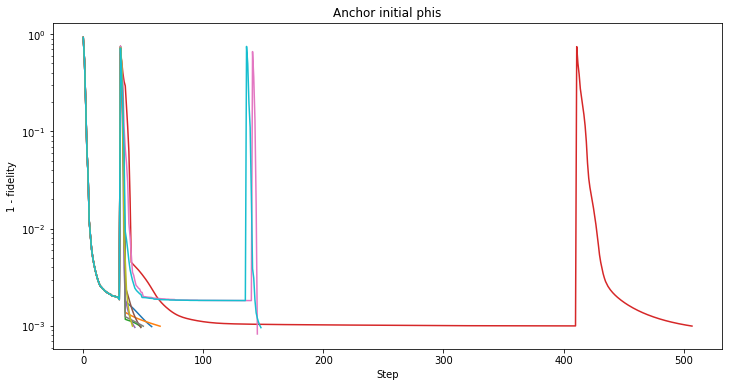

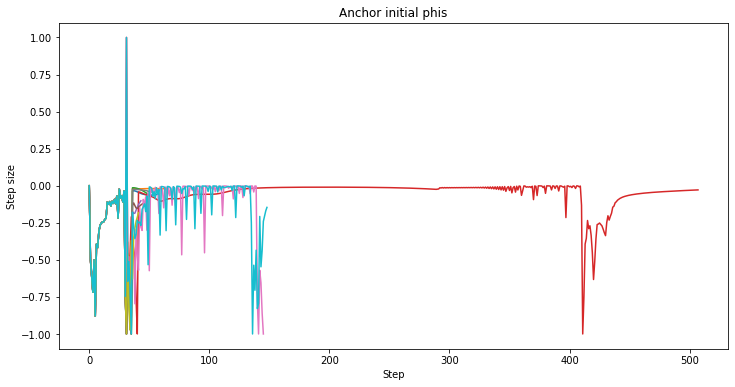

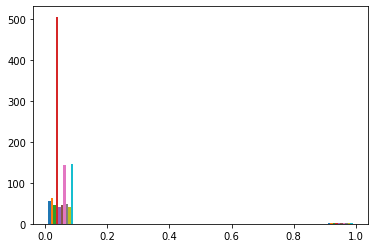

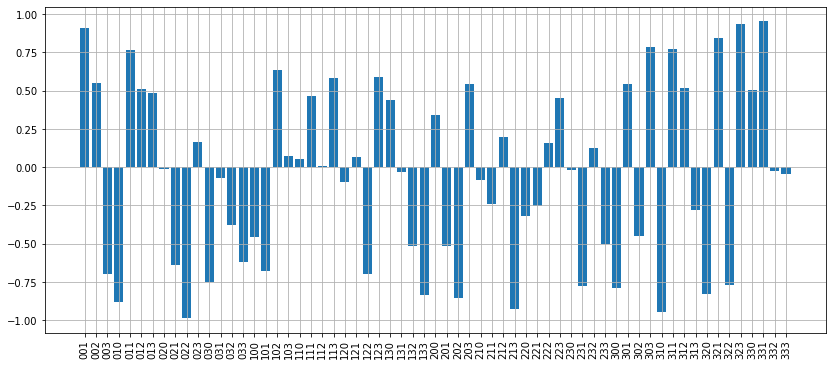

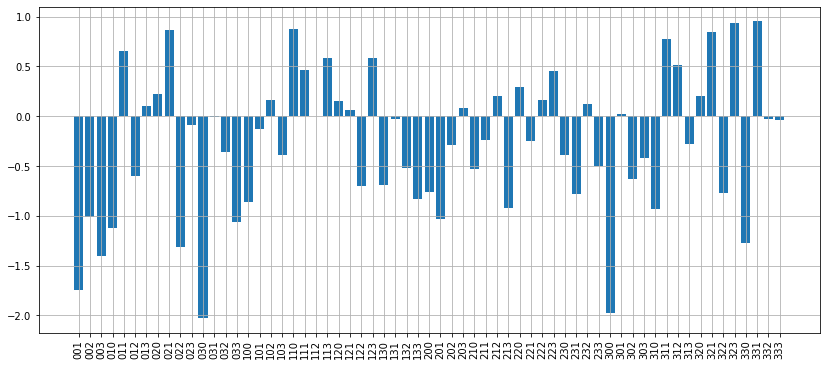

In [25]:
nqubits=3
basis_full = pauli_basis(nqubits)
num_rand_interations = 10

multi_fidelities = []
multi_steps = []
multi_step_sizes = []
multi_indices = []
multi_phis = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices, step_sizes = anchor_init_fidelities(Vtoff, basis_full, num_steps=1000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"\nMax fidelity = {max(fidelities)} @ step {np.argmax(np.array(fidelities))}/{steps[-1]}")
    multi_phis.append(phis)
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_step_sizes.append(step_sizes)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Anchor initial phis")
plot_multi_step_sizes(multi_steps, multi_step_sizes, title="Anchor initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[0])
plot_parameters(basis_full["labels"],phis[-1])

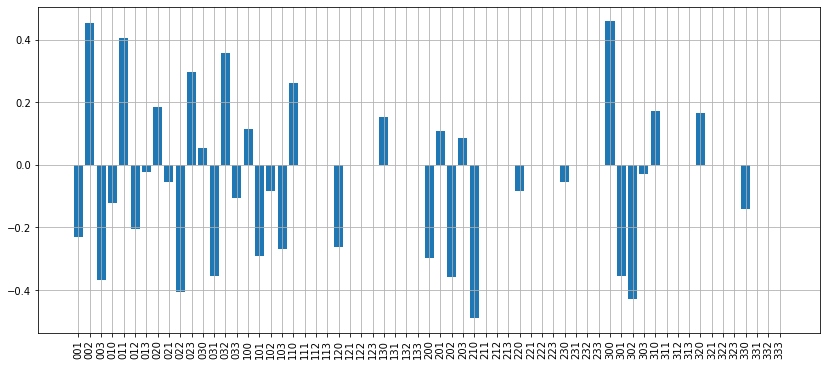

In [13]:
plot_parameters(basis_full["labels"],phis[0])

[1000/1000] [Fidelity = 0.9110578887071095] Omega geodesic gave a positive fidelity update for this step...                                                                    
Max fidelity = 0.9884076589760263 @ step 645/1000
[1000/1000] [Fidelity = 0.8790965606681748] Omega geodesic gave a positive fidelity update for this step...                                                                   
Max fidelity = 0.9434587637495915 @ step 431/1000
[62/1000] A solution!                                                                                                                                                        
Max fidelity = 0.9999146635997112 @ step 62/62


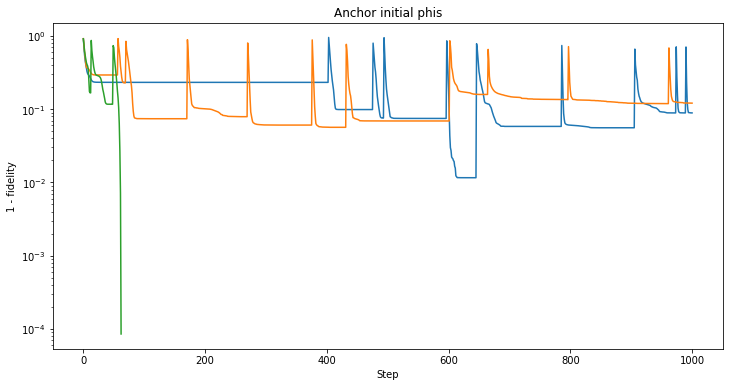

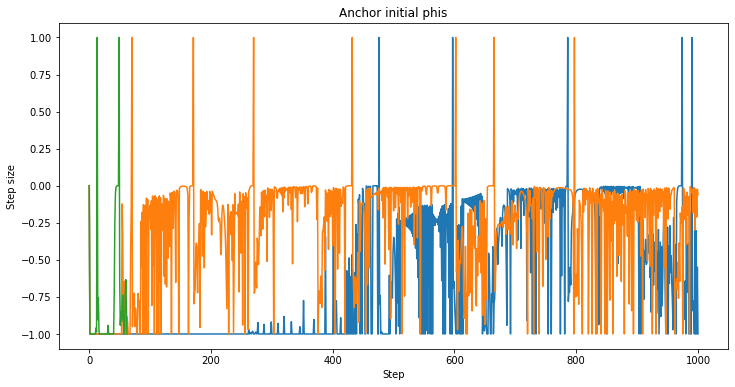

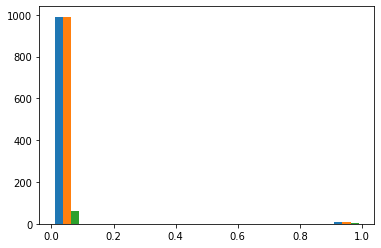

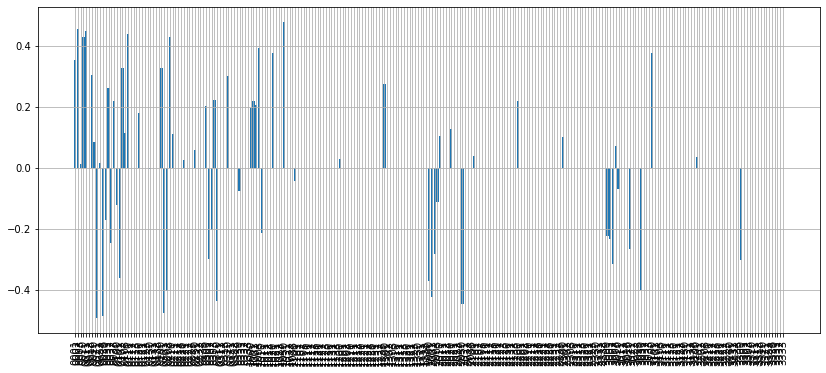

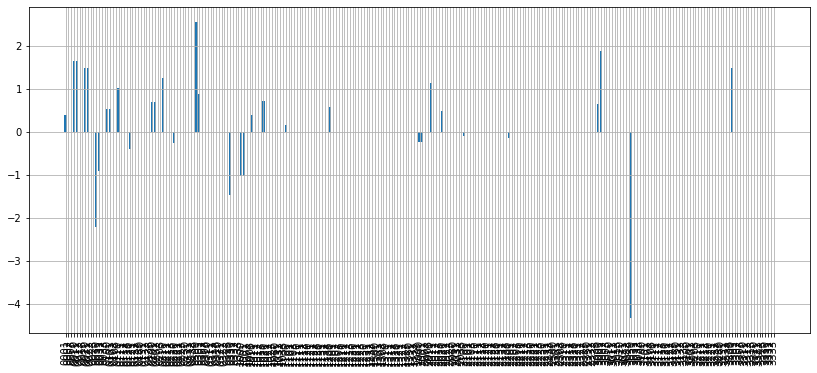

In [1215]:
nqubits=4
basis_full = pauli_basis(nqubits)
num_rand_interations = 3

multi_fidelities = []
multi_steps = []
multi_step_sizes = []
multi_indices = []
multi_phis = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices, step_sizes = anchor_init_fidelities(VparityZ3, basis_full, num_steps=1000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"\nMax fidelity = {max(fidelities)} @ step {np.argmax(np.array(fidelities))}/{steps[-1]}")
    multi_phis.append(phis)
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_step_sizes.append(step_sizes)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Anchor initial phis")
plot_multi_step_sizes(multi_steps, multi_step_sizes, title="Anchor initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[0])
plot_parameters(basis_full["labels"],phis[-1])

[1435/3000] A solution!                                                                                                                                                        
Max fidelity = 0.9990998488411806 @ step 1435/1435


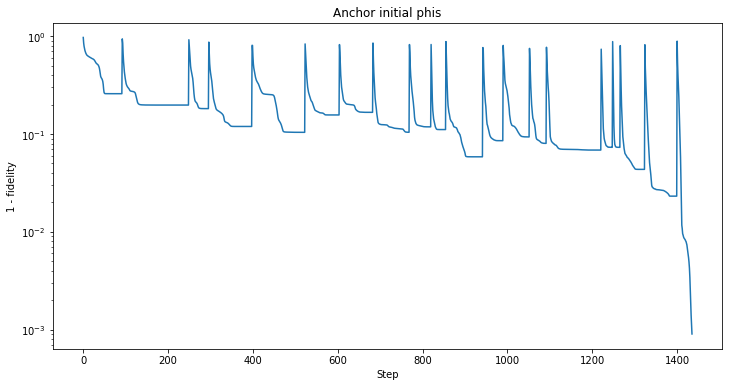

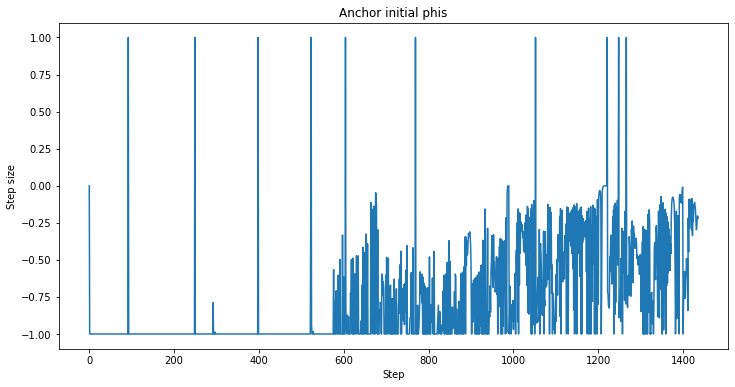

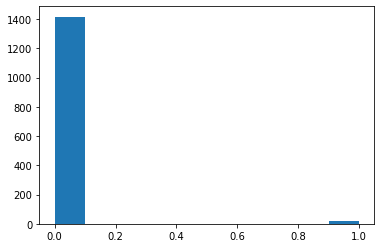

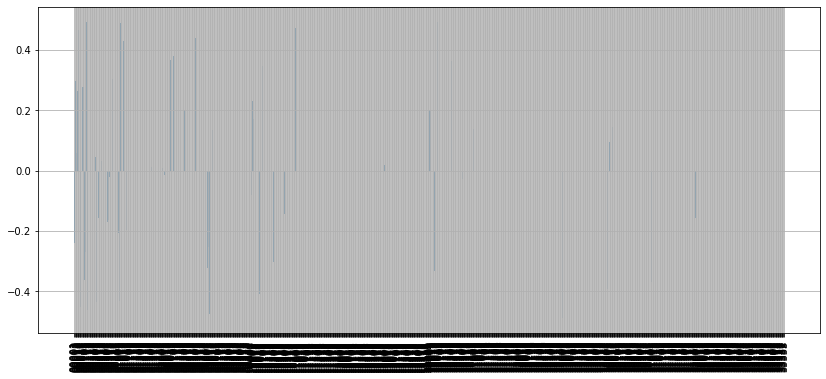

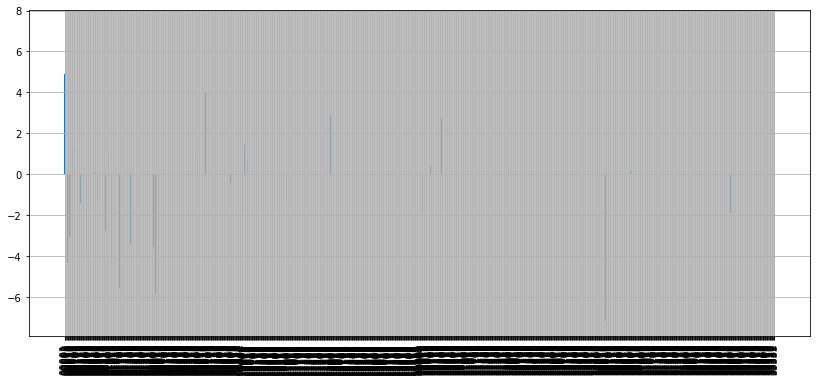

In [1219]:
nqubits=5
basis_full = pauli_basis(nqubits)
num_rand_interations = 1

multi_fidelities = []
multi_steps = []
multi_step_sizes = []
multi_indices = []
multi_phis = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices, step_sizes = anchor_init_fidelities(VparityZ, basis_full, num_steps=3000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"\nMax fidelity = {max(fidelities)} @ step {np.argmax(np.array(fidelities))}/{steps[-1]}")
    multi_phis.append(phis)
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_step_sizes.append(step_sizes)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Anchor initial phis")
plot_multi_step_sizes(multi_steps, multi_step_sizes, title="Anchor initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[0])
plot_parameters(basis_full["labels"],phis[-1])

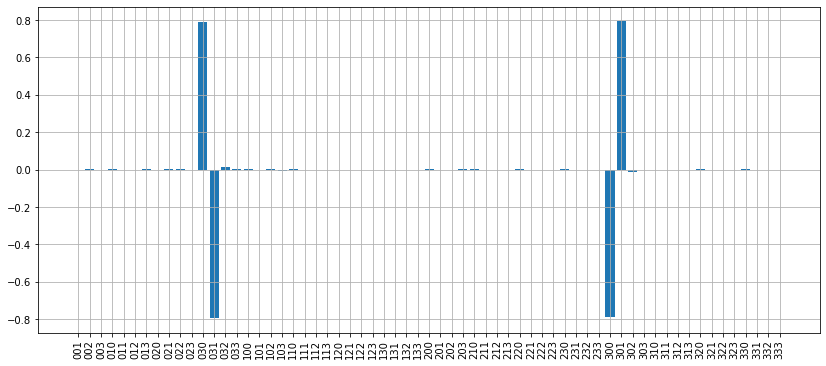

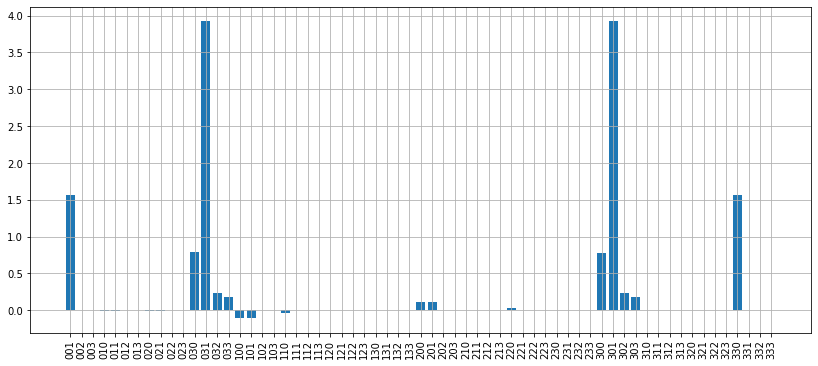

|H1-H2| = (-0.0037453048969631197+6.938893903907228e-18j)
U1 U2 trace fidelity = 0.9997449746163274


In [1205]:
phi1 = multi_phis[3][-1]
phi2 = multi_phis[4][-1]

plot_parameters(basis_full["labels"], phi1)
plot_parameters(basis_full["labels"], phi2)

H1 = hamiltonian_from_parameters(phi1, basis_full["basis"])
H2 = hamiltonian_from_parameters(phi2, basis_full["basis"])

U1 = spla.expm(1.j * H1)
U2 = spla.expm(1.j * H2)
print(f"|H1-H2| = {np.trace(H1.conj().T @ H2)}")
print(f"U1 U2 trace fidelity = {unitary_fidelity(U1, U2)}")

In [1132]:
multi_phis[1][-1]

array([-1.17816354e+00,  1.40905894e-04,  8.46105654e-05, -5.68078368e-06,
        6.55595864e-05, -9.10273364e-05, -6.53056724e-05,  6.09307605e-05,
       -1.77207467e-04,  5.09062155e-05,  7.85430484e-05,  3.92706414e-01,
       -1.96362472e+00,  1.96487623e-04,  1.94052714e-04, -1.07772599e+00,
        8.48000155e-05,  5.21080222e-05, -8.44874956e-06,  1.71861553e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.11244217e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.07773510e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.07332240e+00,
       -6.49472862e-05, -3.63269728e-06, -6.94723298e-05, -5.18424927e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.36717815e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.07333444e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.92691251e-01,
       -7.85456348e-01,  6.46350685e-05,  6.70071097e-05,  9.14180802e-05,
        0.00000000e+00,  

In [1035]:
unitary_from_parameters(phis[-1], basis_full["basis"])/(9.23478186e-01-3.83644032e-01j)

array([[ 1.00000094e+00+9.42216187e-04j, -2.95691578e-04-9.59053051e-04j,
         3.03233745e-04-3.21079841e-05j,  1.57475399e-06+6.22368968e-05j,
        -1.27891990e-04+1.75229633e-04j, -4.10517674e-04-4.24942334e-04j,
         2.37355887e-04-6.80581554e-04j, -9.23024621e-05+7.13501966e-04j],
       [ 2.98786706e-04-9.58406511e-04j,  1.00000098e+00+1.10547286e-03j,
        -3.29125310e-04-3.61064121e-05j,  2.22374777e-05-8.13079800e-05j,
        -1.24922959e-04-4.23805860e-04j,  8.59185111e-05+1.01864493e-04j,
        -2.78760758e-04+5.35770224e-04j,  1.14372354e-04-6.30712179e-04j],
       [-3.03354455e-04-3.48381084e-05j,  3.29526789e-04-3.35621323e-05j,
         9.99999721e-01+1.93342774e-03j, -1.01216773e-05-2.15653964e-04j,
        -4.47621656e-04-4.75808109e-05j,  3.73668254e-04-2.61930160e-04j,
         7.57976597e-04-1.43257174e-05j, -9.39031690e-04+1.61422337e-05j],
       [-1.95234803e-06+6.26435655e-05j, -2.19072788e-05-8.17212668e-05j,
         1.11616674e-05-2.15266936e

In [1036]:
unitary_fidelity(Vtoff, unitary_from_parameters(phis[-1], basis_full["basis"]))

0.9999984093881131

In [1037]:
print(phi)

[-3.92699082e-01 -1.08995891e-17 -2.77555756e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.92699082e-01
  3.92699082e-01  1.08995891e-17  2.77555756e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.92699082e-01
  3.92699082e-01  1.08995891e-17  2.77555756e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.92699082e-01
 -3.92699082e-01 -1.08995

In [1069]:
phi0 = parameters_from_hamiltonian(-1.j*spla.logm(Vqft), basis_full["basis"])
phi = parameters_from_hamiltonian(-1.j*spla.logm(spla.expm(1*spla.logm(Vqft))), basis_full["basis"])
theta = parameters_from_hamiltonian(-1.j*spla.logm(spla.expm(1.45*spla.logm(Vqft))), basis_full["basis"])
theta2 = parameters_from_hamiltonian(-1.j*spla.logm(spla.expm(1.j*1.2*np.diag([1]*8))@spla.expm(spla.logm(Vqft))), basis_full["basis"])
theta3 = parameters_from_hamiltonian(-1.j*spla.logm(spla.expm(1.j*2*np.diag([1]*8))@spla.expm(spla.logm(Vqft))), basis_full["basis"])

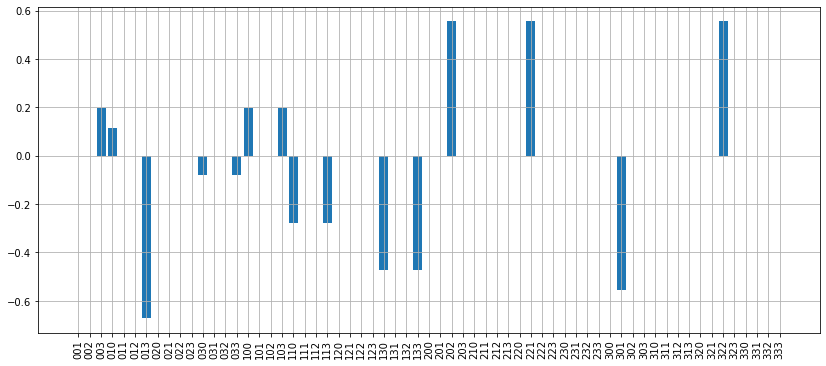

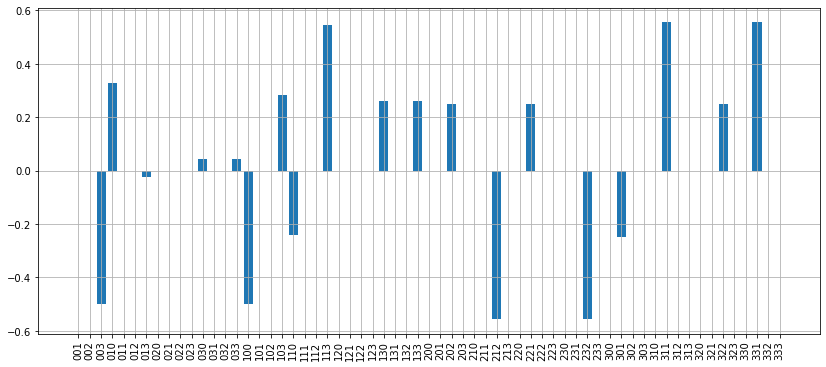

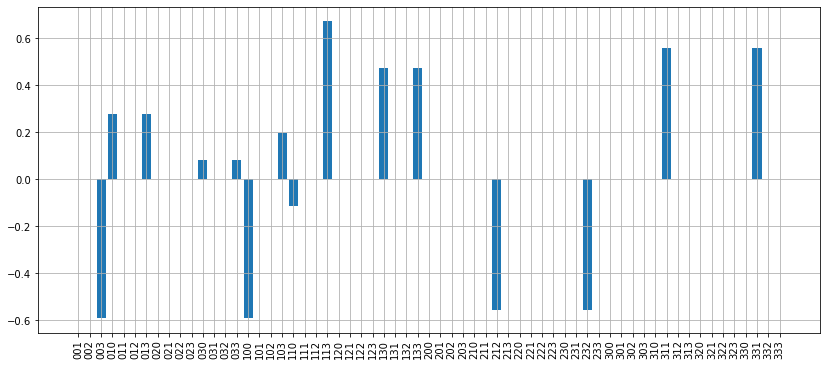

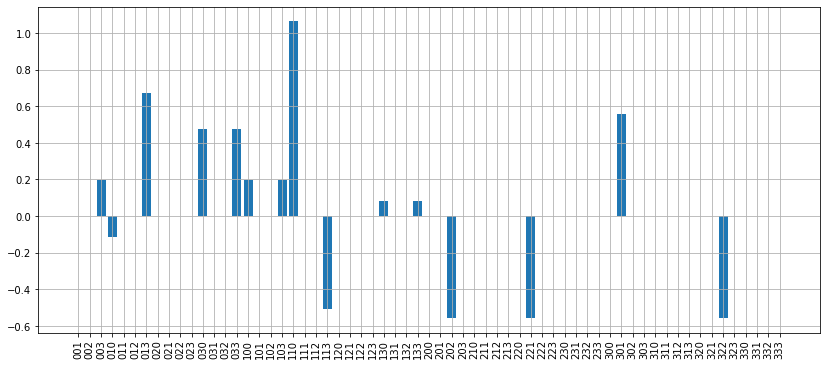

In [1070]:
plot_parameters(basis_full["labels"], phi0)
plot_parameters(basis_full["labels"], theta)
plot_parameters(basis_full["labels"], theta2)
plot_parameters(basis_full["labels"], theta3)

In [1116]:
def three_body_term_cost(theta, indices, norm=None):
    cost = sum([abs(t) if i in indices else 0 for i, t in enumerate(theta)])
    if norm is not None:
        cost /= norm
    return cost
    
thetas = []
costs = []

indices = np.where(np.array(two_body_projection_indices(basis_full)) == 0)[0]
phase = np.linspace(0,8*np.pi,1000)
for p in phase:
    thetas.append(parameters_from_hamiltonian(-1.j*spla.logm(spla.expm(1.j*p*np.diag([1]*8))@spla.expm(spla.logm(Vqft))), basis_full["basis"]))
    costs.append(three_body_term_cost(thetas[-1], indices))
min_theta = thetas[np.argmin(np.array(costs))]

In [ ]:
costs

In [ ]:
thetas = []
costs = []

indices = np.where(np.array(two_body_projection_indices(basis_full)) == 0)[0]
phase = np.linspace(0,8*np.pi,10000)
for p in phase:
    thetas.append(parameters_from_hamiltonian(-1.j*spla.logm(spla.expm((1+p)*spla.logm(Vqft))), basis_full["basis"]))
    costs.append(three_body_term_cost(thetas[-1], indices, norm=(1+p)))
min_theta = thetas[np.argmin(np.array(costs))]

In [ ]:
costs

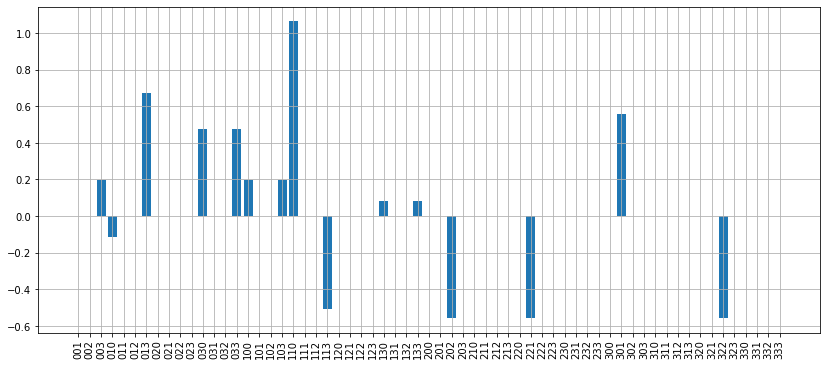

In [1117]:
plot_parameters(basis_full["labels"], min_theta)

In [5]:
a = np.array([[1,2],[2,1]])

In [6]:
a

array([[1, 2],
       [2, 1]])

In [7]:
len(a)

2

In [8]:
type(a)

numpy.ndarray